In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import colors as mcolors
from IPython.display import HTML, Image

In [2]:
LW_ACT = 2
LW_OUT = 2
LW = 4

ALPHA_ACT_INT = 0.5
ALPHA_OUT_CUR = 0.5


def set_ax_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['bottom'].set_linewidth(LW)
    ax.tick_params(axis=u'both', which=u'both',length=0, pad=15)
    
def set_outcome_regular_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

def set_pp_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_linewidth(LW)
    ax.tick_params(axis='x', which=u'both',length=0, pad=15)
    
    
def thick_frame(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for edge in ['top', 'bottom', 'left', 'right']:
        ax.spines[edge].set_linewidth(LW)
    ax.tick_params(axis=u'both', which=u'both',length=0, pad=15)
    
    
def scatter_outcome_w_line(ax, X, y, color, obs_marker_size, label, linestyle):
    face_color = (color[0], color[1], color[2], 0.2)
    p = ax.scatter(X, y, marker='x', facecolors=face_color, edgecolors=color, s=obs_marker_size, label=label, linestyle=linestyle, lw=1.0)
    return p
    
    
def scatter_outcome(ax, X, y, color, obs_marker_size, label):
    p = ax.scatter(X, y, marker='x', facecolors=color, s=obs_marker_size, label=label)
    return p
    
    
def plot_outcome(ax, xx, f_mean, color, label, linestyle, alpha, lw=LW_OUT):
    l, = ax.plot(xx, f_mean, color=color, linewidth=lw, alpha=alpha, linestyle=linestyle, label=label)
    return l
    
def plot_outcome_texts(ax, X, y, observation_texts, color):
    for xi, yi, txt in zip(X, y, observation_texts):
        ax.annotate(txt, (xi-0.06, yi+0.2), fontsize=FS, color=color)
        
def plot_x_ticks(ax, X, x_texts):
    _ = ax.set_xticks(X, x_texts, fontsize=FS)
    
def set_regions(ax, start, end, ymax, fc=0.9):
    line = ax.axvline(start, linestyle="--", color="grey", zorder=-1)
    span = ax.axvspan(start, end, facecolor=f'{fc}', zorder=-1)
    return span
    
    
def plot_action(ax, t, lw, action_marker_size, marker_color, label, linestyle):
    ax.vlines(t, -0.05, 0.19, color=marker_color, linewidth=lw, linestyle=linestyle)
    ax.scatter(t, [0.25] * len(t), marker='o', edgecolor=marker_color, linewidth=lw, facecolor='none',
               s=action_marker_size, label=label)
    p = ax.scatter(t, [0.25] * len(t), marker='o', edgecolor='none', linewidth=lw, facecolor=marker_color,
               s=action_marker_size, alpha=0.2)
    return p


def scatter_action(ax, t, lw, action_marker_size, marker_color, label, linestyle='-'):
    face_color = (marker_color[0], marker_color[1], marker_color[2], 0.2)
    p = ax.scatter(t, [0.25] * len(t), marker='o', 
                   facecolor=face_color, 
                   edgecolor=marker_color, 
                   linewidth=lw, s=action_marker_size, label=label, linestyle=linestyle)
    return p


def scatter_action_black(ax, t, lw, action_marker_size, marker_color, label, linestyle='-'):
    p = ax.scatter(t, [0.25] * len(t), marker='o', 
                   facecolor=marker_color, 
                   edgecolor='black', 
                   linewidth=lw, s=action_marker_size, label=label, linestyle=linestyle)
    return p

def scatter_action_colored(ax, t, lw, action_marker_size, face_color, edge_color, label, linestyle='-', alpha=1.0, y=0.24):
    p = ax.scatter(t, [y] * len(t), marker='o', 
                   facecolor=face_color, 
                   edgecolor=edge_color, 
                   linewidth=lw, s=action_marker_size, label=label, linestyle=linestyle, alpha=alpha)
    return p


def scatter_action_line(ax, t, lw, marker_color, linestyle):
    l = ax.vlines(t, -0.05, 0.15, color=marker_color, linewidth=lw, linestyle=linestyle)
    return l


def scatter_action_line_dynamic(ax, t, start, end, lw, marker_color, linestyle, alpha=1.0):
    l = ax.vlines(t, start, end, color=marker_color, linewidth=lw, linestyle=linestyle, alpha=alpha)
    return l
    
    
def plot_intensity(ax, xx, lamb, color, linestyle, label, alpha=ALPHA_ACT_INT):
    l, = ax.plot(xx, lamb, color=color, linewidth=LW_ACT, alpha=alpha, linestyle=linestyle, label=label)
    return l

In [3]:
def mask_until(ei):
    mask_x = X <= ei
    mask_xx = xx <= ei
    mask_t = t <= ei
    return X[mask_x], y[mask_x], xx[mask_xx], f_mean[mask_xx], t[mask_t], lamb[mask_xx]


def mask_until_extrapolate(ei, T):
    mask_x = np.logical_end(X <= ei, X > T/2)
    mask_xx = np.logical_end(xx <= ei, xx > T/2)
    mask_t = np.logical_end(t <= ei, t > T/2)
    return X[mask_x], y[mask_x], xx[mask_xx], f_mean[mask_xx], t[mask_t], lamb[mask_xx]


def plot_until(ei):
    Xm, ym, xxm, f_meanm, tm, lambm = mask_until(ei)
    po = scatter_outcome(axd['outcome'], Xm, ym, obs_outcome_color, obs_marker_size, label=r'$\mathbf{y_{obs}}$')
    lo = plot_outcome(axd['outcome'], xxm, f_meanm, obs_outcome_color, linestyle='-', label=r'$\mathbf{f_{obs}}$', alpha=1.0)
    pal = scatter_action_line_dynamic(axd['action'], tm, start=-0.05, end=0.15, lw=3, marker_color='black', linestyle='-')
    pa = scatter_action_black(axd['action'], tm, lw=3, action_marker_size=action_marker_size, marker_color=obs_action_color, label=r'$\mathbf{a_{obs}}$')
    la = plot_intensity(axd['action'], xxm, lambm, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
    return lo, la, po, pa, pal,


def init_fig():
    lo, la, po, pa, pal = plot_until(0.0)
    return lo, la, po, pa, pal

obs_marker_size = 100
action_marker_size = 200


normal_effect = lambda ti, x, a, mu, sigma: a * np.exp(-(np.power((x-mu-ti)/sigma, 2)))
gamma_effect = lambda x: ((1/1.16) * 0.1 *
                          (x ** (2.5 - 1)) * np.exp(-1.0 * x))
normal_bump = lambda x, a, mu, sigma: a * np.exp(-(np.power((x-mu)/sigma, 2)))


def f_joint(x, t):
    baseline = f(x)
    sigma = 0.4
    a = 0.4
    mu = 0.8
    for ti in t:
        baseline += normal_effect(ti, x, a, mu, sigma)
    return baseline

f = lambda x: np.exp(-0.5 * x) + 0.2

T = 10
np.random.seed(2)
t = np.array([1.3, 3.7, 7.5])
N = len(t)
X = np.random.uniform(0.0, T, 15)
xx = np.linspace(0.0, T, 100)
y = f_joint(X, t) + np.random.randn(X.shape[0]) * 0.15
f_mean = f_joint(xx, t)
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=7.5, sigma=0.8)
# lamb2 = normal_bump(xx, a=1.0, mu=1.5, sigma=0.6)

all_obs_events = np.sort(np.concatenate([np.linspace(0.0, T/2, 100), X[X < T/2], t[t < T/2], [T/2]]))

### PP Counterfactual

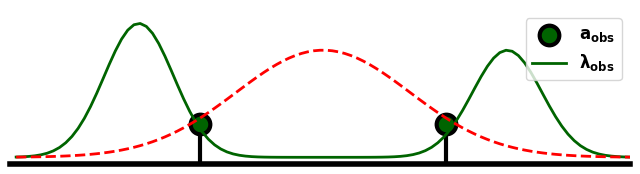

In [4]:
def mask_until(ei):
    mask_x = X <= ei
    mask_xx = xx <= ei
    mask_t = t <= ei
    return X[mask_x], y[mask_x], xx[mask_xx], f_mean[mask_xx], t[mask_t], lamb[mask_xx]


def mask_until_cf(ei):
    mask_x = X <= ei
    mask_xx = xx <= ei
    mask_t = t_cf <= ei
    return X[mask_x], y[mask_x], xx[mask_xx], f_mean[mask_xx], t_cf[mask_t], lamb_cf[mask_xx]


def mask_until_extrapolate(ei, T):
    mask_x = np.logical_end(X <= ei, X > T/2)
    mask_xx = np.logical_end(xx <= ei, xx > T/2)
    mask_t = np.logical_end(t <= ei, t > T/2)
    return X[mask_x], y[mask_x], xx[mask_xx], f_mean[mask_xx], t[mask_t], lamb[mask_xx]


def plot_until_action(ei, axa):
    Xm, ym, xxm, f_meanm, tm, lambm = mask_until(ei)
    pal = scatter_action_line_dynamic(axa, tm, start=-0.05, end=0.17, lw=3, marker_color='black', linestyle='-')
    pa = scatter_action_black(axa, tm, lw=3, action_marker_size=action_marker_size, marker_color=obs_action_color, label=r'$\mathbf{a_{obs}}$')
    la = plot_intensity(axa, xxm, lambm, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
    return la, pa, pal,


def plot_until_action_cf(ei, axa):
    Xm, ym, xxm, f_meanm, tm, lambm = mask_until_cf(ei)
    pal = scatter_action_line_dynamic(axa, tm, start=-0.05, end=0.17, lw=3, marker_color='black', linestyle='-')
    pa = scatter_action_black(axa, tm, lw=3, action_marker_size=action_marker_size, marker_color=cf_action_color, label=r'$\mathbf{a_{cf}}$')
    la = plot_intensity(axa, xxm, lambm, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
    return la, pa, pal,


def init_fig_action(axa):
    la, pa, pal = plot_until_action(0.0, axa)
    return la, pa, pal,


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image

obs_marker_size = 100
action_marker_size = 200


normal_effect = lambda ti, x, a, mu, sigma: a * np.exp(-(np.power((x-mu-ti)/sigma, 2)))
gamma_effect = lambda x: ((1/1.16) * 0.1 *
                          (x ** (2.5 - 1)) * np.exp(-1.0 * x))
normal_bump = lambda x, a, mu, sigma: a * np.exp(-(np.power((x-mu)/sigma, 2)))


def f_joint(x, t):
    baseline = f(x)
    sigma = 0.4
    a = 0.4
    mu = 0.8
    for ti in t:
        baseline += normal_effect(ti, x, a, mu, sigma)
    return baseline

f = lambda x: np.exp(-0.5 * x) + 0.2
lamb_fnc = lambda x: normal_bump(x, a=1.0, mu=1.0, sigma=0.4) + 0.8 * normal_bump(x, a=1.0, mu=4.0, sigma=0.4)
lamb_cf_fnc = lambda x: 0.8 * normal_bump(x, a=1.0, mu=2.5, sigma=1.0)

T = 5
np.random.seed(2)
t = np.array([1.5, 3.5, 7.5])
t_cf = np.array([])
N = len(t)
X = np.random.uniform(0.0, T, 15)
xx = np.linspace(0.0, T, 100)
y = f_joint(X, t) + np.random.randn(X.shape[0]) * 0.15
f_mean = f_joint(xx, t)
lamb = lamb_fnc(xx)
lamb_cf = lamb_cf_fnc(xx)

all_obs_events = np.sort(np.concatenate([np.linspace(0.0, T/2, 100), X[X < T/2], t[t < T/2], [T/2]]))
    
fig = plt.figure(figsize=(8, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
int_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['lightgreen'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
init_fig_action(ax)
ax.legend(loc='upper right', fontsize=12)
plot_until_action(T, ax)
plot_until_action_cf(T, ax)
plt.show()

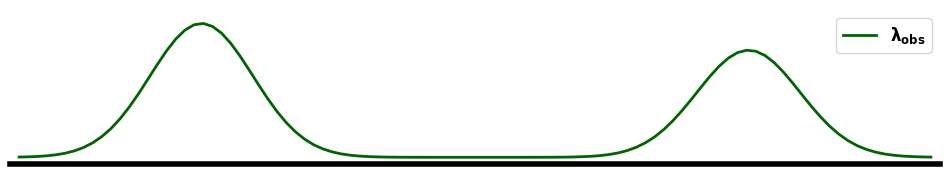

In [5]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t = np.array([])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T+0.05)
plt.savefig('figures/cfpp/1-lambda_obs.pdf')

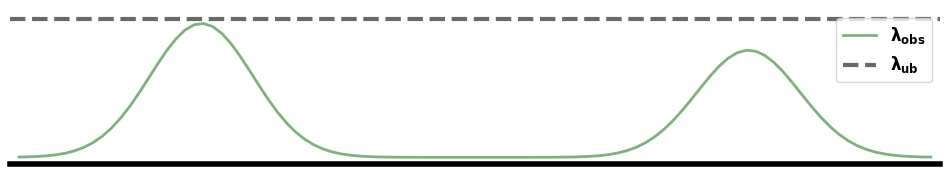

In [6]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t = np.array([])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
ax.axhline(1.03, color='dimgray', lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T+0.05)
plt.savefig('figures/cfpp/2-lambda_ub.pdf')

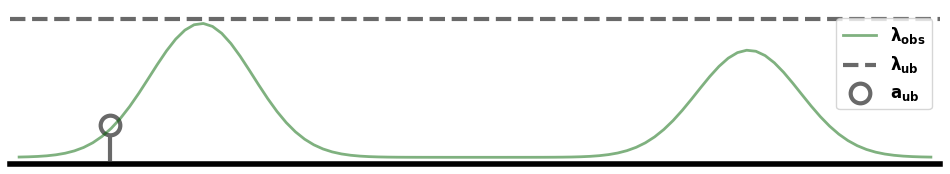

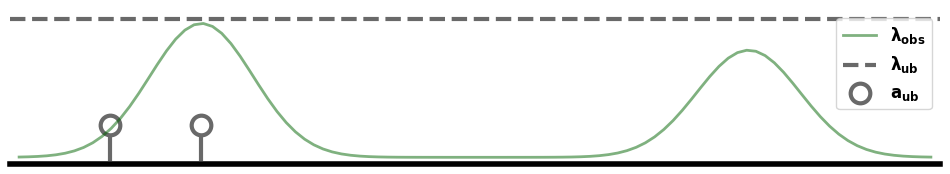

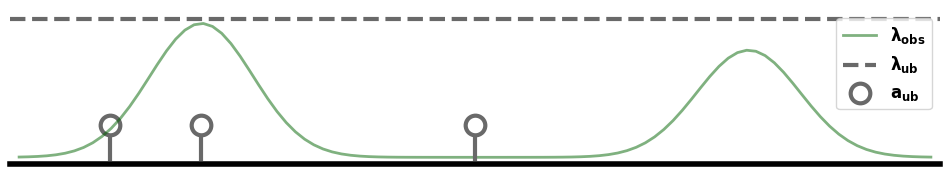

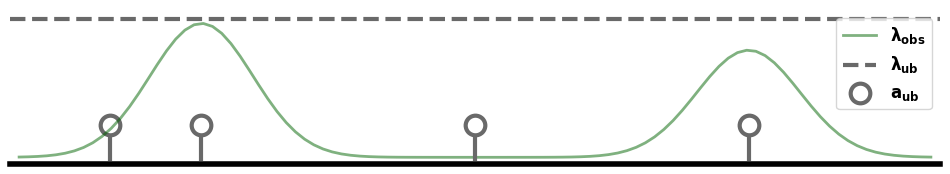

In [7]:
porder = 3
for ii in range(1, 5):
    fig = plt.figure(figsize=(12, 2))
    ax = plt.subplot(1, 1, 1)
    set_pp_frame(ax)

    ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
    T = 5
    np.random.seed(2)
    N = len(t)
    xx = np.linspace(0.0, T, 100)
    t_ub = np.array([0.5, 1.0, 2.5, 4.0])[:ii]
#     lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
    la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
    ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$')
    pal = scatter_action_line_dynamic(ax, t_ub, start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
    pa = scatter_action_colored(ax, t_ub, lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
    ax.legend(loc='upper right', fontsize=12)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(-0.05, T+0.05)
    plt.savefig(f'figures/cfpp/{porder}-lambda_ub_samples{ii}.pdf')
    porder += 1

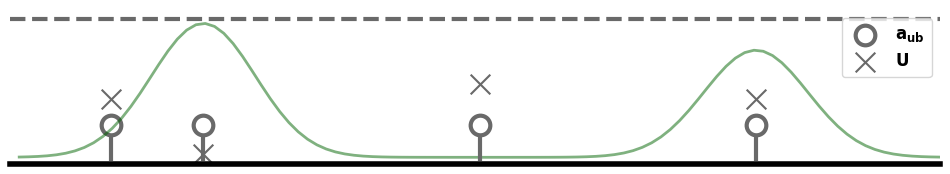

In [8]:
np.random.seed(3)


fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', alpha=0.5, label=None)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--')
pal = scatter_action_line_dynamic(ax, t_ub, start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_ub, lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
U = np.random.uniform(0.0, 1.0, 4)
scatter_outcome(ax, t_ub, U, ub_action_color, obs_marker_size=200, label=r'$\mathbf{U}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/7-u_samples.pdf')

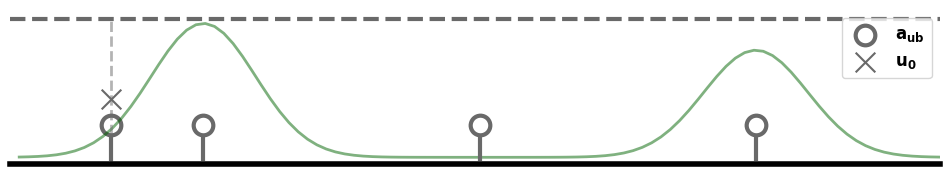

In [9]:
uidx = 0
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_ub, start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_ub, lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
scatter_outcome(ax, t_ub[uidx], U[uidx], ub_action_color, obs_marker_size=200, label=r'$\mathbf{u_0}$')
ax.axvline(t_ub[uidx], ymax=0.95, color=ub_action_color, lw=2, linestyle='--', alpha=0.5)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/8-thinning_u0.pdf')

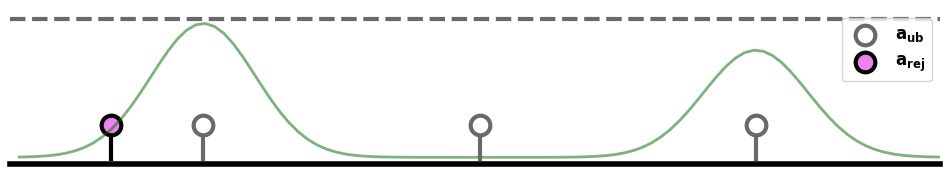

In [10]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 1
ridx = [0,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_upper = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_upper[uidx:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_upper[uidx:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/9-thinning_u0_rej.pdf')

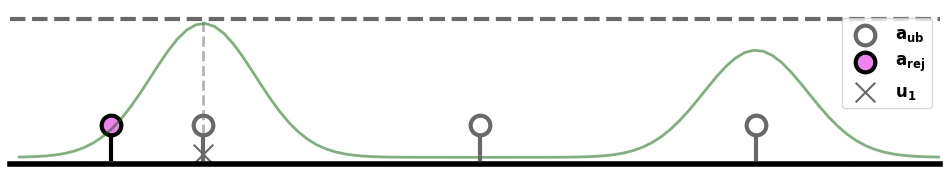

In [11]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 1
ridx = [0,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_upper = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_upper[uidx:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_upper[uidx:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
scatter_outcome(ax, t_ub[uidx], U[uidx], ub_action_color, obs_marker_size=200, label=r'$\mathbf{u_1}$')
ax.axvline(t_ub[uidx], ymax=0.95, color=ub_action_color, lw=2, linestyle='--', alpha=0.5)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/10-thinning_u1.pdf')

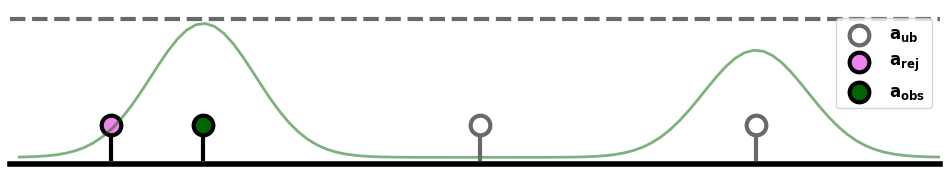

In [12]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 1

ridx = [0,]
oidx = [1,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_upper = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/11-thinning_u1_acc.pdf')

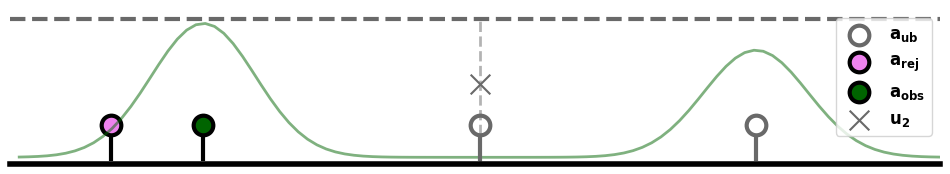

In [13]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,]
oidx = [1,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_upper = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_upper[uidx:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_upper[uidx:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
scatter_outcome(ax, t_ub[uidx], U[uidx], ub_action_color, obs_marker_size=200, label=r'$\mathbf{u_2}$')
ax.axvline(t_ub[uidx], ymax=0.95, color=ub_action_color, lw=2, linestyle='--', alpha=0.5)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/12-thinning_u2.pdf')

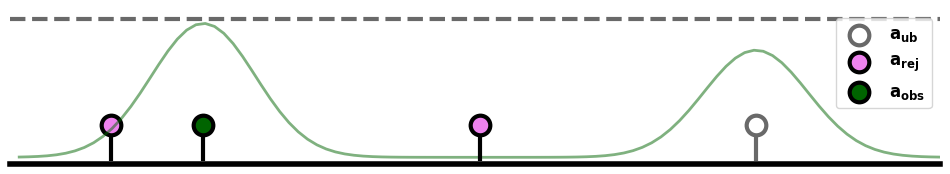

In [14]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_ub[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_ub[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/13-thinning_u2_rej.pdf')

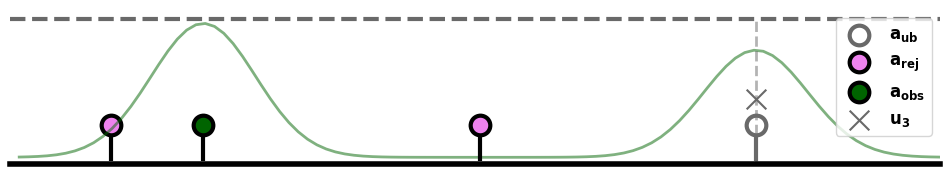

In [15]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 3

ridx = [0,2]
oidx = [1,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
pal = scatter_action_line_dynamic(ax, t_ub[uidx:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
pa = scatter_action_colored(ax, t_ub[uidx:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
scatter_outcome(ax, t_ub[uidx], U[uidx], ub_action_color, obs_marker_size=200, label=r'$\mathbf{u_3}$')
ax.axvline(t_ub[uidx], ymax=0.95, color=ub_action_color, lw=2, linestyle='--', alpha=0.5)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/14-thinning_u3.pdf')

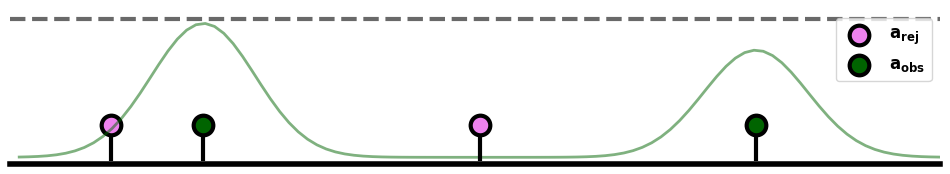

In [16]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=None, alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=None)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/15-thinning_u3_acc.pdf')

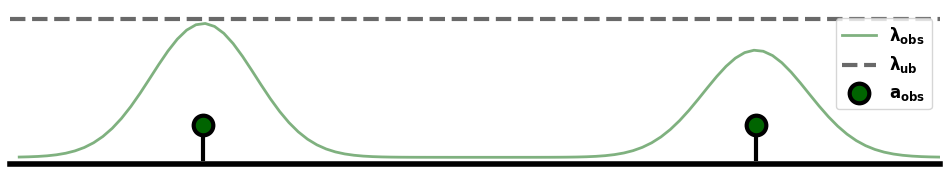

In [17]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/16-thinning_obs.pdf')

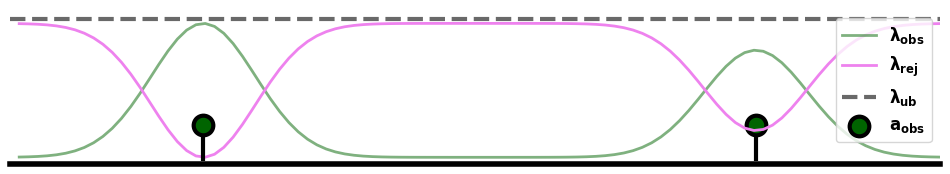

In [18]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
la = plot_intensity(ax, xx, 1 - lamb, color=rej_action_color, linestyle='-', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/17-thinning_int_rej.pdf')

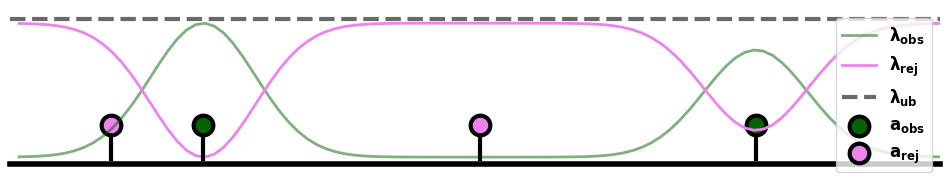

In [19]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
la = plot_intensity(ax, xx, 1 - lamb, color=rej_action_color, linestyle='-', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/18-thinning_int_rej_w_samples.pdf')

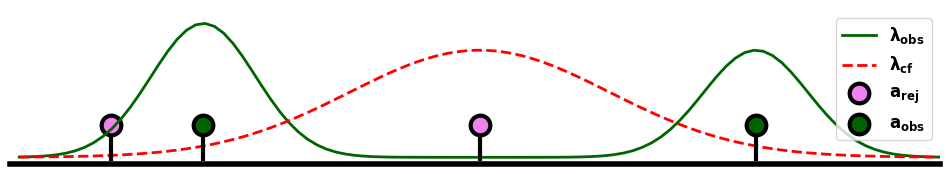

In [20]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_upper = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/19-thinning_int_cf.pdf')

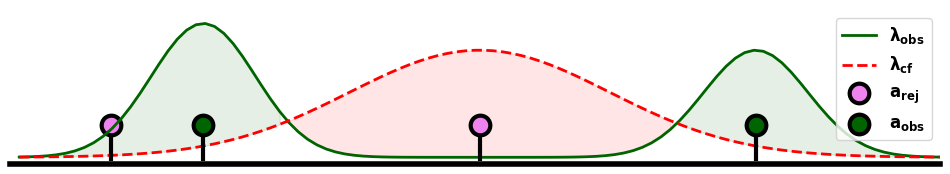

In [21]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_upper[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/20-thinning_int_cf.pdf')

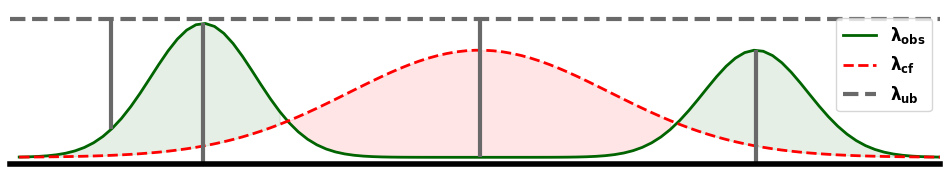

In [22]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = lamb_fnc(xx)
# lamb_cf = lamb_cf_fnc(xx)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
ax.vlines(t_ub[oidx], -0.05, lamb_fnc(t_ub[oidx]), colors='dimgray', lw=3, linestyle='-')
ax.vlines(t_ub[ridx], lamb_fnc(t_ub[ridx]), 1.03, colors='dimgray', lw=3, linestyle='-')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/21-thinning_cf_noise.pdf')

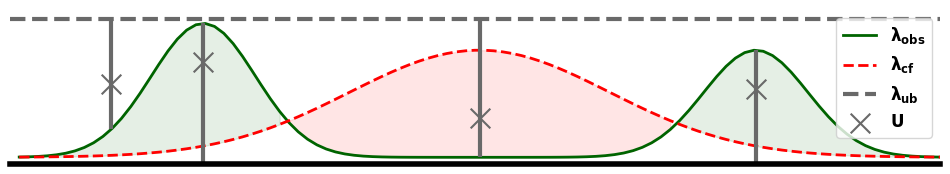

In [23]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(3)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = lamb_fnc(xx)
# lamb_cf = lamb_cf_fnc(xx)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
ax.vlines(t_ub[oidx], -0.05, lamb_fnc(t_ub[oidx]), colors='dimgray', lw=3, linestyle='-')
ax.vlines(t_ub[ridx], lamb_fnc(t_ub[ridx]), 1.03, colors='dimgray', lw=3, linestyle='-')
U = np.random.uniform(0.0, 1.0, 4)
scatter_outcome(ax, t_ub, U, ub_action_color, obs_marker_size=200, label=r'$\mathbf{U}$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/22-thinning_cf_resample.pdf')

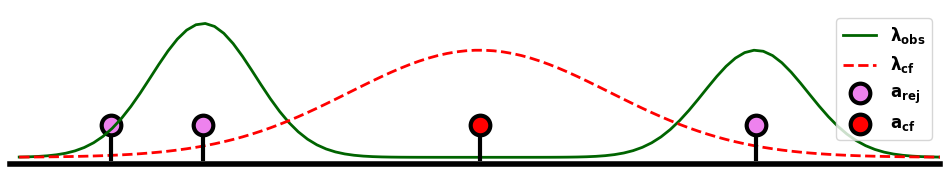

In [24]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,1,3]
oidx = [2,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, marker_color='black', lw=3, linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, 
                            face_color=cf_action_color, edge_color='black',
                            label=r'$\mathbf{a_{cf}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/23-thinning_cf_rethin.pdf')

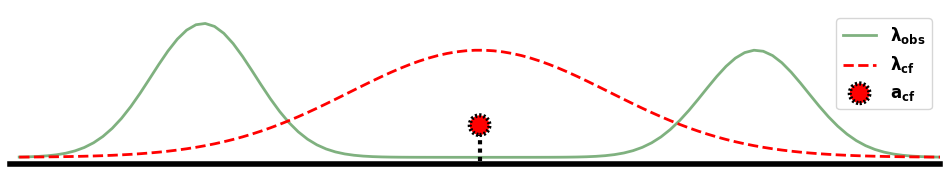

In [25]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,1,3]
oidx = [2,]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.0, 2.5, 4.0])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, marker_color='black', 
                                  lw=3, linestyle=(0, (1., 1.)))
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, 
                            face_color=cf_action_color, edge_color='black', linestyle=(0, (0.5, 0.5)),
                            label=r'$\mathbf{a_{cf}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/24-thinning_cf_out.pdf')

In [26]:
action_marker_size

200

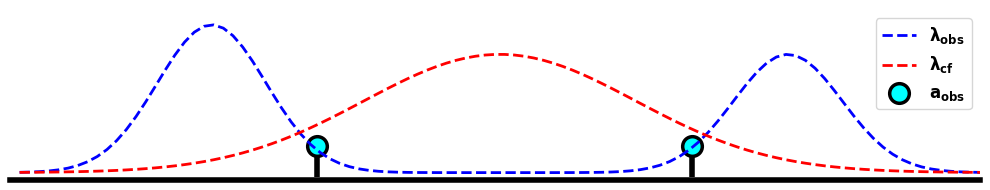

In [27]:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.11, lw=4, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], y=0.18, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-1.pdf')

In [28]:
t_ub[oidx][0]

1.55

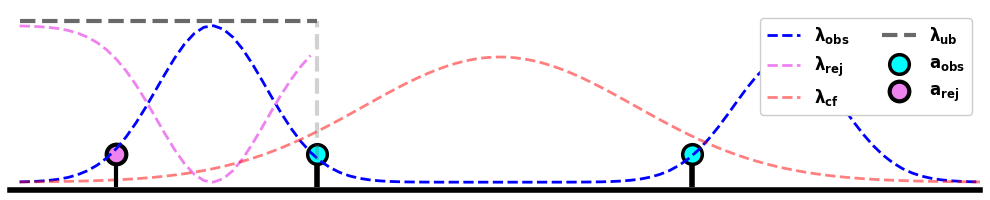

In [29]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = xx <= t_ub[oidx][0]+0.01
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx[interval_mask], 1-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=0.5)
ax.hlines(1.03, xmin=0.0, xmax=t_ub[oidx][0], color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.vlines(t_ub[oidx][0], 0.0, 1.03, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.11, lw=4, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], y=0.18, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx][:1], start=-0.03, end=0.11, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx][:1], y=0.18, lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-2.pdf')

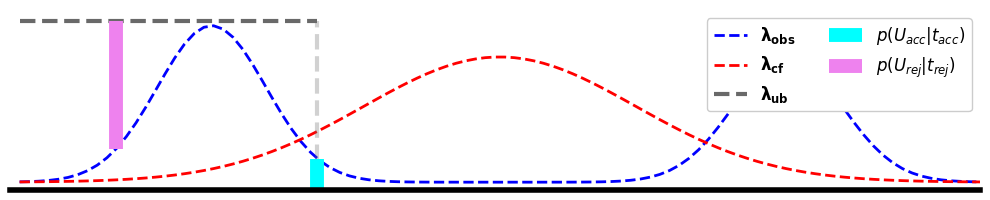

In [30]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = xx <= t_ub[oidx][0]+0.01
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
# la = plot_intensity(ax, xx[interval_mask], 1-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.hlines(1.03, xmin=0.0, xmax=t_ub[oidx][0], color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.vlines(t_ub[oidx][0], 0.0, 1.03, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)
ax.vlines(t_ub[oidx][:1], -0.05, lamb_fnc(t_ub[oidx][:1]), colors=obs_action_color, lw=10, linestyle='-', label=r'$p(U_{acc}| t_{acc})$')
ax.vlines(t_ub[ridx][:1], lamb_fnc(t_ub[ridx][:1]), 1.03, colors=rej_action_color, lw=10, linestyle='-', label=r'$p(U_{rej}| t_{rej})$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=4, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx], lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx][:1], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx][:1], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-3.pdf')

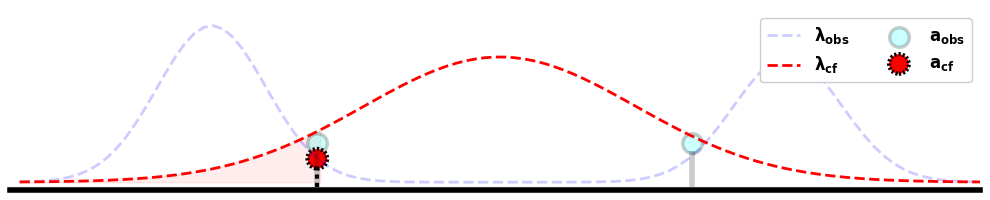

In [31]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = xx <= t_ub[oidx][0]+0.01
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.2)
# la = plot_intensity(ax, xx[interval_mask], 1-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
ax.fill_between(xx[xx <= t_ub[oidx][0]+0.03], 0.0, lamb_cf[xx <= t_ub[oidx][0]+0.03], color=cf_action_color, alpha=0.075)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.hlines(1.03, xmin=0.0, xmax=t_ub[oidx][0], color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# ax.vlines(t_ub[oidx][0], 0.0, 1.03, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)
# ax.vlines(t_ub[oidx][:1], -0.05, lamb_fnc(t_ub[oidx][:1]), colors=obs_action_color, lw=6, linestyle='-', label=r'$p(U_{acc}| t_{acc})$')
# ax.vlines(t_ub[ridx][:1], lamb_fnc(t_ub[ridx][:1]), 1.03, colors=rej_action_color, lw=6, linestyle='-', label=r'$p(U_{rej}| t_{rej})$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.20, lw=4, marker_color='black', linestyle='-', alpha=0.2)
pa = scatter_action_colored(ax, t_ub[oidx], y=0.25, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$', alpha=0.2)
pal = scatter_action_line_dynamic(ax, t_ub[oidx][:1], start=-0.03, end=0.10, marker_color='black', lw=3, linestyle=(0, (1.0, 1.0)))
pa = scatter_action_colored(ax, t_ub[oidx][:1], y=0.15, lw=3, action_marker_size=action_marker_size, linestyle=(0, (0.5, 0.5)),
                            face_color=cf_action_color, edge_color='black', label=r'$\mathbf{a_{cf}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx][:1], start=-0.03, end=0.11, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx][:1], y=0.18, lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-4.pdf')

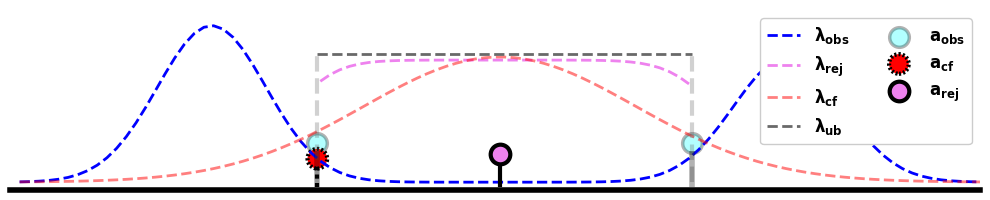

In [32]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = np.logical_and(xx > t_ub[oidx][0], xx <= t_ub[oidx][1]+0.01)
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx[interval_mask], 0.78-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=0.5)
ax.hlines(0.82, xmin=t_ub[oidx][0], xmax=t_ub[oidx][1], color=ub_action_color, lw=2, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.vlines(t_ub[oidx][:2], 0.0, 0.82, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.20, lw=4, marker_color='black', linestyle='-', alpha=0.3)
pa = scatter_action_colored(ax, t_ub[oidx], y=0.25, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$', alpha=0.3)
pal = scatter_action_line_dynamic(ax, t_ub[oidx][:1], start=-0.03, end=0.10, marker_color='black', lw=3, linestyle=(0, (1.0, 1.0)))
pa = scatter_action_colored(ax, t_ub[oidx][:1], y=0.15, lw=3, action_marker_size=action_marker_size, linestyle=(0, (0.5, 0.5)),
                            face_color=cf_action_color, edge_color='black', label=r'$\mathbf{a_{cf}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[oidx][1:2], start=-0.03, end=0.11, lw=4, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx][1:2], y=0.18, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx][1:2], start=-0.03, end=0.11, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx][1:2], y=0.18, lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-5.pdf')

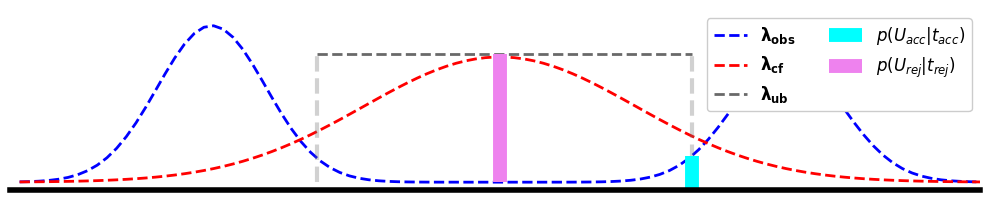

In [33]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = np.logical_and(xx > t_ub[oidx][0], xx <= t_ub[oidx][1]+0.01)
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
# la = plot_intensity(ax, xx[interval_mask], 1-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)

ax.hlines(0.82, xmin=t_ub[oidx][0], xmax=t_ub[oidx][1], color=ub_action_color, lw=2, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.vlines(t_ub[oidx][:2], 0.0, 0.82, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)

ax.vlines(t_ub[oidx][1:2], -0.05, lamb_fnc(t_ub[oidx][1:2]), colors=obs_action_color, lw=10, linestyle='-', label=r'$p(U_{acc}| t_{acc})$')
ax.vlines(t_ub[ridx][1:2], lamb_fnc(t_ub[ridx][1:2]), 0.82, colors=rej_action_color, lw=10, linestyle='-', label=r'$p(U_{rej}| t_{rej})$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=4, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx], lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx][:1], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx][:1], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-6.pdf')

In [34]:
oidx

[1, 3]

In [35]:
ridx

[0, 2]

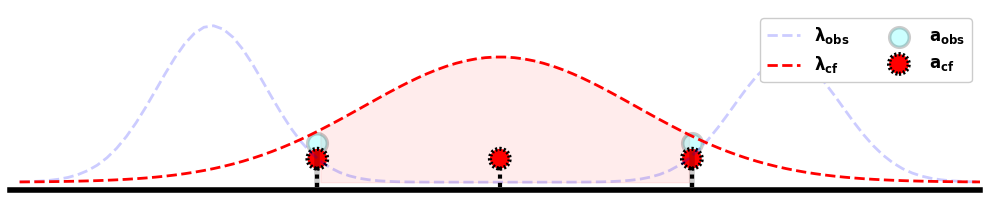

In [36]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]
cidx = [1,2,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = np.logical_and(xx > t_ub[oidx][0], xx <= t_ub[oidx][1]+0.01)
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.2)
ax.fill_between(xx[interval_mask], 0.0, lamb_cf[interval_mask], color=cf_action_color, alpha=0.075)
# la = plot_intensity(ax, xx[interval_mask], 1-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.hlines(1.03, xmin=0.0, xmax=t_ub[oidx][0], color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# ax.vlines(t_ub[oidx][0], 0.0, 1.03, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)
# ax.vlines(t_ub[oidx][:1], -0.05, lamb_fnc(t_ub[oidx][:1]), colors=obs_action_color, lw=6, linestyle='-', label=r'$p(U_{acc}| t_{acc})$')
# ax.vlines(t_ub[ridx][:1], lamb_fnc(t_ub[ridx][:1]), 1.03, colors=rej_action_color, lw=6, linestyle='-', label=r'$p(U_{rej}| t_{rej})$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.20, lw=4, marker_color='black', linestyle='-', alpha=0.2)
pa = scatter_action_colored(ax, t_ub[oidx], y=0.25, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$', alpha=0.2)
pal = scatter_action_line_dynamic(ax, t_ub[cidx], start=-0.03, end=0.10, marker_color='black', lw=3, linestyle=(0, (1.0, 1.0)))
pa = scatter_action_colored(ax, t_ub[cidx], y=0.15, lw=3, action_marker_size=action_marker_size, linestyle=(0, (0.5, 0.5)),
                            face_color=cf_action_color, edge_color='black', label=r'$\mathbf{a_{cf}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx][:1], start=-0.03, end=0.11, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx][:1], y=0.18, lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-7.pdf')

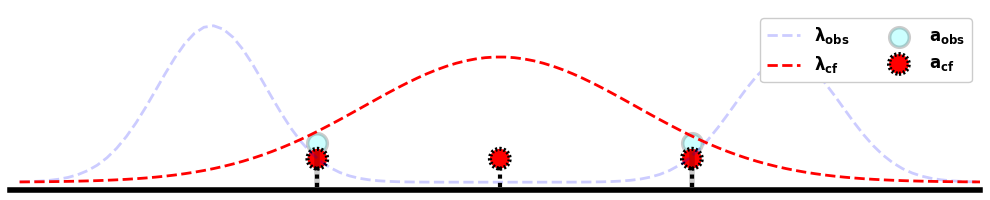

In [37]:
fig = plt.figure(figsize=(10, 2.1))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]
cidx = [1,2,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['cyan'])
obs_intensity_color = mcolors.to_rgba(mcolors.CSS4_COLORS['blue'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
interval_mask = np.logical_and(xx > t_ub[oidx][0], xx <= t_ub[oidx][1]+0.01)
la = plot_intensity(ax, xx, lamb, color=obs_intensity_color, linestyle='--', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.2)
# ax.fill_between(xx[interval_mask], 0.0, lamb_cf[interval_mask], color=cf_action_color, alpha=0.075)
# la = plot_intensity(ax, xx[interval_mask], 1-lamb[interval_mask], color=rej_action_color, linestyle='--', label=r'$\mathbf{\lambda_{rej}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.hlines(1.03, xmin=0.0, xmax=t_ub[oidx][0], color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# ax.vlines(t_ub[oidx][0], 0.0, 1.03, color=ub_action_color, lw=3, linestyle='--', alpha=0.3)
# ax.vlines(t_ub[oidx][:1], -0.05, lamb_fnc(t_ub[oidx][:1]), colors=obs_action_color, lw=6, linestyle='-', label=r'$p(U_{acc}| t_{acc})$')
# ax.vlines(t_ub[ridx][:1], lamb_fnc(t_ub[ridx][:1]), 1.03, colors=rej_action_color, lw=6, linestyle='-', label=r'$p(U_{rej}| t_{rej})$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.20, lw=4, marker_color='black', linestyle='-', alpha=0.2)
pa = scatter_action_colored(ax, t_ub[oidx], y=0.25, lw=2.5, action_marker_size=200, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$', alpha=0.2)
pal = scatter_action_line_dynamic(ax, t_ub[cidx], start=-0.03, end=0.10, marker_color='black', lw=3, linestyle=(0, (1.0, 1.0)))
pa = scatter_action_colored(ax, t_ub[cidx], y=0.15, lw=3, action_marker_size=action_marker_size, linestyle=(0, (0.5, 0.5)),
                            face_color=cf_action_color, edge_color='black', label=r'$\mathbf{a_{cf}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx][:1], start=-0.03, end=0.11, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx][:1], y=0.18, lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
ax.legend(loc='upper right', ncol=2, fontsize=12, framealpha=1.0)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.tight_layout()
plt.savefig('figures/paper/counterfactual_sampling-8.pdf')

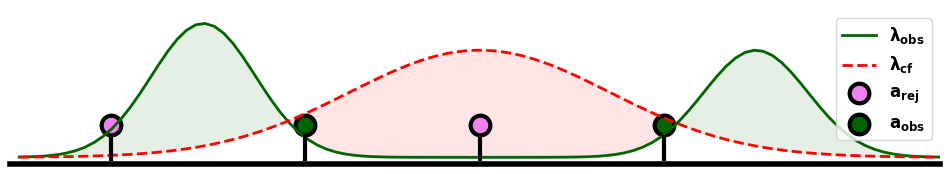

In [38]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/26-thinning_int_cf.pdf')

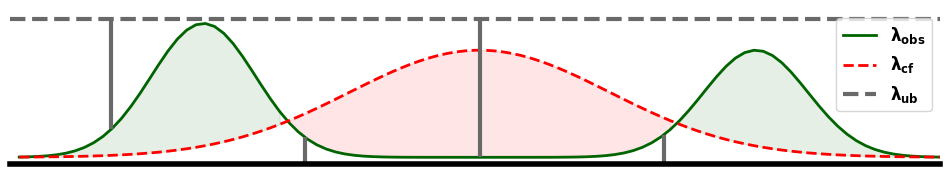

In [39]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = lamb_fnc(xx)
# lamb_cf = lamb_cf_fnc(xx)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
ax.vlines(t_ub[oidx], -0.05, lamb_fnc(t_ub[oidx]), colors='dimgray', lw=3, linestyle='-')
ax.vlines(t_ub[ridx], lamb_fnc(t_ub[ridx]), 1.03, colors='dimgray', lw=3, linestyle='-')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/27-thinning_cf_noise.pdf')

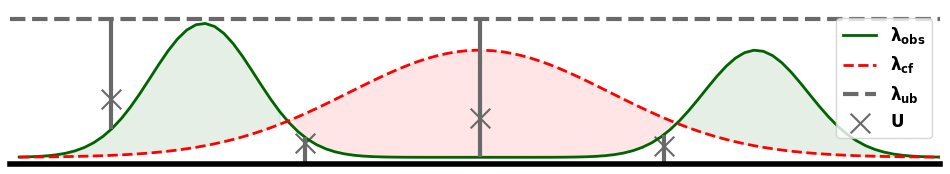

In [40]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0,2]
oidx = [1,3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(3)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = lamb_fnc(xx)
# lamb_cf = lamb_cf_fnc(xx)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
ax.vlines(t_ub[oidx], -0.05, lamb_fnc(t_ub[oidx]), colors='dimgray', lw=3, linestyle='-')
ax.vlines(t_ub[ridx], lamb_fnc(t_ub[ridx]), 1.03, colors='dimgray', lw=3, linestyle='-')
U = []
for i, ti in enumerate(t_ub):
    u = np.random.uniform(0.0, 1 - lamb_fnc(ti)) if i in [0, 2] else np.random.uniform(0.0, lamb_fnc(ti))
    U.append(u)
scatter_outcome(ax, t_ub, U, ub_action_color, obs_marker_size=200, label=r'$\mathbf{U}$')
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
# pal = scatter_action_line_dynamic(ax, t_upper[oidx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, face_color=obs_action_color, edge_color='black', label=r'$\mathbf{a_{obs}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/28-thinning_cf_resample.pdf')

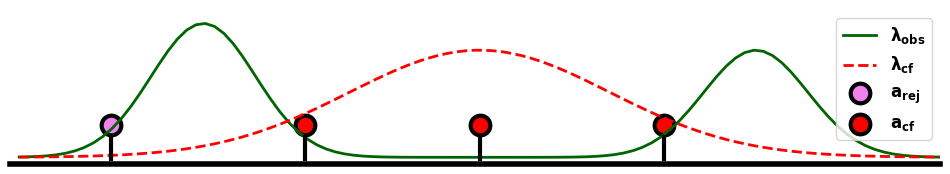

In [41]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0, ]
oidx = [1, 2, 3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=1.0)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, marker_color='black', lw=3, linestyle='-')
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, 
                            face_color=cf_action_color, edge_color='black',
                            label=r'$\mathbf{a_{cf}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/29-thinning_cf_rethin.pdf')

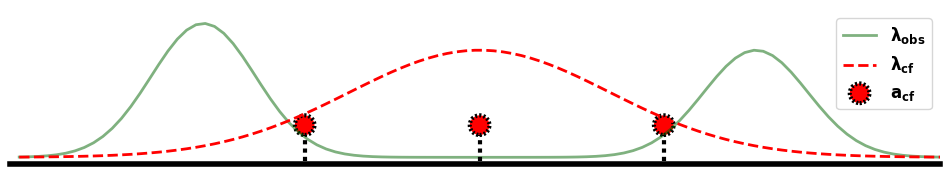

In [42]:
fig = plt.figure(figsize=(12, 2))
ax = plt.subplot(1, 1, 1)
set_pp_frame(ax)

uidx = 2

ridx = [0, ]
oidx = [1, 2, 3]

ub_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['dimgray'])
obs_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['darkgreen'])
rej_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['violet'])
cf_action_color = mcolors.to_rgba(mcolors.CSS4_COLORS['red'])
T = 5
np.random.seed(2)
N = len(t)
xx = np.linspace(0.0, T, 100)
t_ub = np.array([0.5, 1.55, 2.5, 3.5])
# lamb = normal_bump(xx, a=1.0, mu=1.0, sigma=0.4) + normal_bump(xx, a=1.0, mu=4.0, sigma=0.4)
# lamb_cf = normal_bump(xx, a=1.0, mu=2.5, sigma=1.0)
mask_obs_g_cf1 = np.logical_and(lamb > lamb_cf, xx < 2.5)
mask_obs_g_cf2 = np.logical_and(lamb > lamb_cf, xx > 2.5)
mask_cf_leq_obs = lamb < lamb_cf

la = plot_intensity(ax, xx, lamb, color=obs_action_color, linestyle='-', label=r'$\mathbf{\lambda_{obs}}$', alpha=0.5)
la = plot_intensity(ax, xx, lamb_cf, color=cf_action_color, linestyle='--', label=r'$\mathbf{\lambda_{cf}}$', alpha=1.0)
# ax.fill_between(xx[mask_obs_g_cf1], lamb_cf[mask_obs_g_cf1], lamb[mask_obs_g_cf1], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_obs_g_cf2], lamb_cf[mask_obs_g_cf2], lamb[mask_obs_g_cf2], color=obs_action_color, alpha=0.1)
# ax.fill_between(xx[mask_cf_leq_obs], lamb_cf[mask_cf_leq_obs], lamb[mask_cf_leq_obs], color=cf_action_color, alpha=0.1)
# ax.axhline(1.03, color=ub_action_color, lw=3, linestyle='--', label=r'$\mathbf{\lambda_{ub}}$',)
# pal = scatter_action_line_dynamic(ax, t_upper[uidx+1:], start=-0.03, end=0.17, lw=3, marker_color=ub_action_color, linestyle='-')
# pa = scatter_action_colored(ax, t_upper[uidx+1:], lw=3, action_marker_size=action_marker_size, face_color='white', edge_color=ub_action_color, label=r'$\mathbf{a_{ub}}$')
# pal = scatter_action_line_dynamic(ax, t_ub[ridx], start=-0.03, end=0.17, lw=3, marker_color='black', linestyle='-')
# pa = scatter_action_colored(ax, t_ub[ridx], lw=3, action_marker_size=action_marker_size, face_color=rej_action_color, edge_color='black', label=r'$\mathbf{a_{rej}}$')
pal = scatter_action_line_dynamic(ax, t_ub[oidx], start=-0.03, end=0.17, marker_color='black', 
                                  lw=3, linestyle=(0, (1., 1.)))
pa = scatter_action_colored(ax, t_ub[oidx], lw=3, action_marker_size=action_marker_size, 
                            face_color=cf_action_color, edge_color='black', linestyle=(0, (0.5, 0.5)),
                            label=r'$\mathbf{a_{cf}}$')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, T)
plt.savefig('figures/cfpp/30-thinning_cf_out.pdf')